In [56]:
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../../RKLM_Python/')
# Path to output files
sys.path.append('../')

import numpy as np
import utils
import plotting_tools as pt

from importlib import reload
import utils
utils = reload(utils)
pt = reload(pt)

from scipy import signal
import pickle

from numpy import linalg as la

cm = 1/2.54

# Plot for the rising bubble experiment
Initial conditions, and comparisons with blended solutions. Anything non-ensemble related is here.

## Comparison plots for psinc, imbalance and blended probe measurements 

probe_loc = (20, 40)
w/o blending - psinc: 17.433566
blending - psinc: 0.056948
probe_loc = (20, 40)
$\delta_{\rm{i}}$=1308.5618
$\delta_{\rm{b}}$=4.2745
probe_loc = (80, 40)
$\delta_{\rm{i}}$=24.0587
$\delta_{\rm{b}}$=0.0627


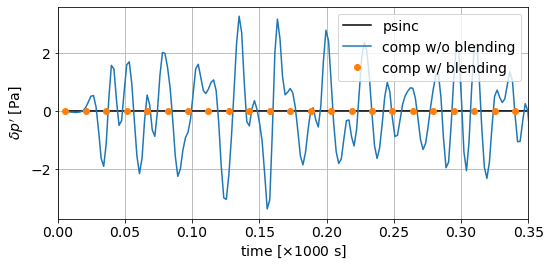

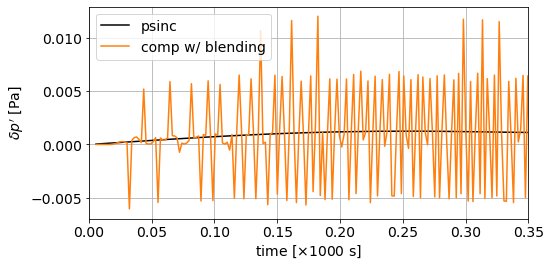

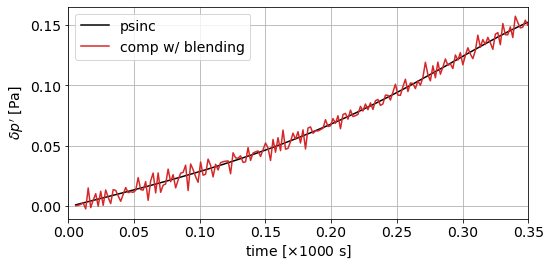

In [128]:
attributes = ['rho','rhou','rhov','rhoY','p2_nodes']
attributes = ['p2_nodes']
# attributes = ['p2_half']

base_fn = "output_rising_bubble"
directory = "output_rising_bubble"

py_directory = "../../%s/" %directory

et = 1.0
N = 1
Nx, Ny = 160, 80
tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
times = np.arange(0,527)[1:] # Ma ~ 0.0341
times = np.arange(0,185)[1:]
# times = np.arange(0,630)[1:]

probe_loc = [20,40]
l_typ = 'WINDOW_STEP'

rhoY = False
CFL = False

attr_labels = pt.labels_increment()

def ic_loader(tc,sfx1, swe):
    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx1,format='dat')
    path_pickle = tc.get_path(fn_pickle)

    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    file.close()

    return ud

def p_converter(ens,rhoY,ud, sfx):
    dp2n = np.array([ (at_t - at_t.mean()) * ud.Msq for at_t in ens ])
    kernel = np.ones((2,2))
    dp2c = np.array([signal.fftconvolve(item, kernel, mode='valid') / kernel.sum() for item in dp2n])

    if 'psinc' in sfx:
        P0 = (rhoY**(ud.gamm-1.0) + dp2c)**(1.0/(ud.gamm-1.0))
        p = P0**(ud.gamm)
    else:
        P0 = (rhoY**(ud.gamm-1.0) - dp2c)**(1.0/(ud.gamm-1.0))
        p = rhoY**(ud.gamm) - P0**(ud.gamm)

#     if 'psinc' in sfx:
#         p = (rhoY**(ud.gamm-1.0) + dp2c)**(1.0/(ud.gamm-1.0))
#         p = p**(ud.gamm)
#     else:
#         p = (rhoY**(ud.gamm-1.0) + dp2c)**(1.0/(ud.gamm-1.0))**ud.gamm
#         p = (dp2c)**(1.0/(ud.gamm-1.0))**ud.gamm
#         p = rhoY**(ud.gamm)

    p *= ud.p_ref
    return p

def get_ens(sfx , diff, attribute):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=False)
    rhoY = tc.get_ensemble(times, N, 'rhoY', sfx, label_type=l_typ, avg=True, diff=False)
    
    tt = tc.t_arr
    ens = ens[1:]
    rhoY = rhoY[1:]
    tt = tt[1:]
    ud = ic_loader(tc,sfx,False)
    
    p = p_converter(ens,rhoY,ud,sfx)

    probe = p[:,probe_loc[0],probe_loc[1]]
    probe = probe[1:] - probe[:-1]
    
#     probe *= p_ref * Msq
#     probe = probe[1:] - probe[:-1]
    
    label = sfx + '_' + attribute
    return label, probe, tt

pls = []
ss = 'idt=2'

for i,attribute in enumerate(attributes):
    diff = True if attribute == 'p2_nodes' or attribute == 'p2_half' else False

    sfx1 = 'psinc_noib'
    if CFL : sfx1 = 'psinc_noib_CFLfixed'
    attribute1 = 'p2_nodes'
    if rhoY : attribute1 = 'rhoY'
    l1, p1, tt = get_ens(sfx1, diff, attribute1)
    l1 = 'psinc'
    
    sfx2 = 'comp_imbal_noib'
    if CFL : sfx2 = 'comp_imbal_noib_CFLfixed'
    attribute2 = 'p2_nodes'
    if rhoY : attribute2 = 'rhoY'
    l2_attr = np.copy(attribute2)
    l2, p2, tt = get_ens(sfx2, diff, attribute2)
    l2 = 'comp w/o blending'
    
    sfx3 = 'comp_imbal_half_ib-0'
    if CFL : sfx3 = 'comp_imbal_CFLfixed_ib-0'
    attribute3 = 'p2_nodes'
    if rhoY : attribute3 = 'rhoY'
    l3, p3, tt = get_ens(sfx3, diff, attribute3)
    l3 = 'comp w/ blending'

    ########################################
    #
    ########################################
    print("====================")
    
    fs = (20*cm,10*cm) # used in the publication
    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)
    
    if diff == True:
        tt = tt[1:]
    
    ax.plot(tt, p1, 'k', ms=4, label=l1)
    ax.plot(tt, p2, 'C0', label=l2)
    ax.plot(tt, p3, 'C1o', ms=6, markevery=8, label=l3)
    
    ax.set_ylabel(r'$\delta p^\prime$ [Pa]')
    ax.set_xlabel(r'time [$\times 1000$ s]')
    ax.set_xlim([0.0,0.35*et])
    ax.grid()
    ax.legend()
    
    pl.img.tight_layout()
    
    fn = 'rb_%i_%i_w_imbal' %(probe_loc[0],probe_loc[1])
    pl.save_fig('./output/%s' %fn)
    
    print("probe_loc = (%i, %i)" %(probe_loc[0],probe_loc[1]))
    print("w/o blending - psinc: %.6f" %(la.norm(p2-p1)))
    print("blending - psinc: %.6f" %(la.norm(p3-p1)))
    
    
    ########################################
    #
    ########################################
    print("====================")
        
    _, p1, _ = get_ens(sfx1, diff, attribute1)
    _, p2, _ = get_ens(sfx2, diff, attribute2)
    _, p3, _ = get_ens(sfx3, diff, attribute3)

    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)
    
    dist = la.norm(p3-p1)
#     l3a = 'dist=%.4f' %dist
    l3a = ''
    l3a += r'$\delta_{\rm{i}}$=%.4f' %((la.norm(p2-p1))/la.norm(p1))
    l3a += '\n'
    l3a += r'$\delta_{\rm{b}}$=%.4f' %((la.norm(p3-p1))/la.norm(p1))
#     ax.annotate(l3a, (0.025,0.0031))

    ax.plot(tt, p1, 'k', ms=4, label=l1)
    ax.plot(tt, p3, 'C1', ms=6, markevery=1, label=l3)
    
    ax.set_ylabel(r'$\delta p^\prime$ [Pa]')
    ax.set_xlabel(r'time [$\times 1000$ s]')
    ax.set_xlim([0.0,0.35])
    ax.grid()
    ax.legend()
#     ax.text(0.025,0.0033,l3a)
    
    pl.img.tight_layout()
    
    fn = 'rb_%i_%i_w_ib' %(probe_loc[0],probe_loc[1])
    pl.save_fig('./output/%s' %fn)
    
    print("probe_loc = (%i, %i)" %(probe_loc[0],probe_loc[1]))
#     print("blending - psinc: %.6f" %(la.norm(p3-p1)))
    
    print(l3a)
    
    
    ########################################
    #
    ########################################
    print("====================")
    
    probe_loc = [80,40]
    _, p1, _ = get_ens(sfx1, diff, attribute1)
    _, p2, _ = get_ens(sfx2, diff, attribute2)
    _, p3, _ = get_ens(sfx3, diff, attribute3)

    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)
    
    dist = la.norm(p3-p1)
#     l3b = 'dist=%.4f' %dist
    l3b = ''
    l3b += r'$\delta_{\rm{i}}$=%.4f' %((la.norm(p2-p1))/la.norm(p1))
    l3b += '\n'
    l3b += r'$\delta_{\rm{b}}$=%.4f' %((la.norm(p3-p1))/la.norm(p1))
#     ax.annotate(l3b, (0.025,0.05))
#     ax.annotate(l3b, (0.82,-0.225))
    
    ax.plot(tt, p1, 'k', ms=4, label=l1)
    ax.plot(tt, p3, 'C3', ms=6, markevery=1, label=l3)
    
    ax.set_ylabel(r'$\delta p^\prime$ [Pa]')
    ax.set_xlabel(r'time [$\times 1000$ s]')
    ax.set_xlim([0.0,0.35])
    ax.grid()
    ax.legend()
#     ax.text(0.025,0.05,l3b)
    
    pl.img.tight_layout()
    
    fn = 'rb_%i_%i_w_ib' %(probe_loc[0],probe_loc[1])
    pl.save_fig('./output/%s' %fn)
    
    print("probe_loc = (%i, %i)" %(probe_loc[0],probe_loc[1]))
#     print("blending - psinc: %.6f" %(la.norm(p3-p1)))
    
    print(l3b)

## Contour plot of the pressure perturbation

-2.889418514582182 2.9584096934695108


../plotting_tools.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.arr_lst = np.array(arr_lst)


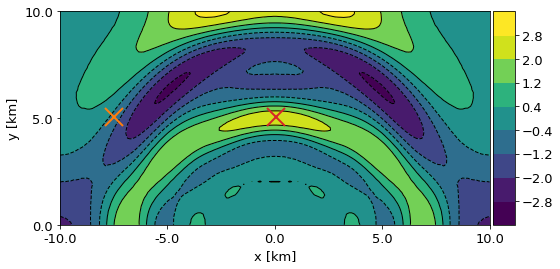

In [92]:
attribute = 'p2_nodes'
et = 1.0
N = 1

base_fn = "output_rising_bubble"
directory = "output_rising_bubble"
py_directory = "../../%s/" %directory

Nx, Ny = 160, 80
euler_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
tags = euler_tc.get_tag_dict()

times = [14,15]
l_typ = 'WINDOW_STEP'
        
prt = utils.prt_time(debug=False)
attr_labels = pt.labels_increment()

def get_ens(tc, sfx , diff, attribute, swe=False):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tags[9])
    rhoY = tc.get_ensemble(times, N, 'rhoY', sfx, label_type=l_typ, avg=True, diff=diff, tag=tags[9])
    ens = ens[1:]
    rhoY = rhoY[1:]
    ud = ic_loader(tc,sfx,swe)
    
    ens = p_converter(ens, rhoY, ud, sfx)
    ens = ens[1] - ens[0]

    label = sfx + '_' + attribute
    return label, ens.T

diff = False
sfx1 = 'debug_rkadv_comp_noib'
sfx1 = 'comp_imbal_noib'
# sfx1 = 'psinc_noib'
# attribute = 'rhoY'
# l1, a1 = get_ens(euler_tc, sfx1, diff, attribute)
attribute = 'p2_nodes'
l2, a2 = get_ens(euler_tc, sfx1, diff, attribute)

print(a2.min(),a2.max())
# pl_lst = [[a1/a2 * 300.0, '']]
pl_lst = [[a2, '']]

pl = pt.plotter(pl_lst,ncols=2,figsize=(30*cm,10*cm),sharey=False,fontsize=13)
x_axs = [-10.0,-5.0,0.0,5.0,10.0]
y_axs = [0.0,5.0,10.0]
if attribute is not 'p2_nodes':
    x_loc = np.linspace(0,Nx-1,5)
    y_loc = np.linspace(0,Ny-1,3)
else:
    x_loc = np.linspace(0,Nx-1,5)
    y_loc = np.linspace(0,Ny-1,3)  
x_label = r'x [km]'
y_label = r'y [km]'
marker = [(20,40,'C1'),(80,40,'C3')]
# marker = [(20,40,'r')]
lvls = np.arange(-1.5,2.5,0.5)
lvls = np.arange(-2.8,3.2,0.8)
# clbl = 'Pa'

pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs,marker=marker, x_label=x_label, y_label=y_label)
_ = pl.plot(aspect='equal',method='contour',lvls=lvls)
pl.save_fig('./output/rb_deltap_contour')

## Comparison of balanced and non-balanced probe measurements for CFL-constrained case

probe_loc = (20, 40)
$\delta_{\rm{i}}$=195.5454
$\delta_{\rm{b}}$=2.9831
probe_loc = (80, 40)
$\delta_{\rm{i}}$=5.4601
$\delta_{\rm{b}}$=0.1823


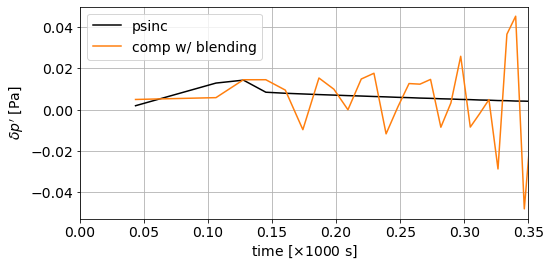

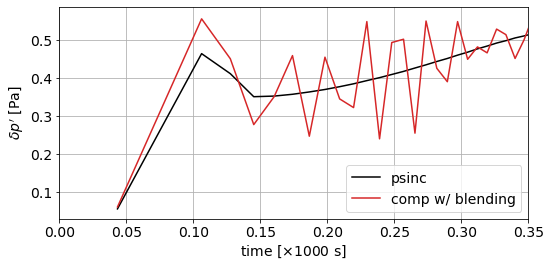

In [125]:
attributes = ['rho','rhou','rhov','rhoY','p2_nodes']
attributes = ['p2_nodes']
# attributes = ['p2_half']

base_fn = "output_rising_bubble"
directory = "output_rising_bubble"

py_directory = "../../%s/" %directory

et = 1.0
N = 1
Nx, Ny = 160, 80
tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)

p_ref = 8.61 * 1e4
# times = np.arange(0,527)[1:]#[:186]
times = np.arange(0,164)#[:19]
times = np.arange(0,30)

probe_loc = [20,40]
# probe_loc = [80,40]
l_typ = 'WINDOW_STEP'

rhoY = False
CFL = True

attr_labels = pt.labels_increment()

def get_ens(sfx , diff, attribute):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=False)
    rhoY = tc.get_ensemble(times, N, 'rhoY', sfx, label_type=l_typ, avg=True, diff=False)
    tt = tc.t_arr
    ens = ens[1:]
    rhoY = rhoY[1:]
    tt = tt[1:]
    
    ud = ic_loader(tc,sfx,False)
    p = p_converter(ens,rhoY,ud, sfx)
    probe = p[:,probe_loc[0],probe_loc[1]]
#     probe *= p_ref * Msq
    probe = probe[1:] - probe[:-1]
    
    label = sfx + '_' + attribute
    return label, probe, tt

pls = []
ss = 'idt=2'

for i,attribute in enumerate(attributes):
    diff = True if attribute == 'p2_nodes' or attribute == 'p2_half' else False

    sfx1 = 'psinc_noib'
    if CFL : sfx1 = 'psinc_noib_CFLfixed'
    attribute1 = 'p2_nodes'
    if rhoY : attribute1 = 'rhoY'
    l1, p1, tt = get_ens(sfx1, diff, attribute1)
    l1 = 'psinc'
    
    sfx2 = 'comp_imbal_noib'
    if CFL : sfx2 = 'comp_imbal_noib_CFLfixed'
    attribute2 = 'p2_nodes'
    if rhoY : attribute2 = 'rhoY'
    l2_attr = np.copy(attribute2)
    l2, p2, tt = get_ens(sfx2, diff, attribute2)
    l2 = 'comp w/o blending'
    
    sfx3 = 'comp_imbal_half_ib-0'
    if CFL : sfx3 = 'comp_imbal_half_CFLfixed_ib-0'
    attribute3 = 'p2_nodes'
    if rhoY : attribute3 = 'rhoY'
    l3, p3, tt = get_ens(sfx3, diff, attribute3)
    l3 = 'comp w/ blending'

    fs = (20*cm,10*cm) # used in the publication
    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)
    
    if diff == True:
        tt = tt[1:]
    
    ax.plot(tt, p1, 'k', ms=4, label=l1)
#     ax.plot(tt, p2, 'C0', label=l2)
    ax.plot(tt, p3, 'C1', ms=6, markevery=1, label=l3)
    
    fn = 'rb_slides'
    
    ax.set_ylabel(r'$\delta p^\prime$ [Pa]')
    ax.set_xlabel(r'time [$\times 1000$ s]')
    ax.set_xlim([0.0,0.35])
    ax.grid()
    ax.legend()
    
    l3a = ''
    l3a += r'$\delta_{\rm{i}}$=%.4f' %((la.norm(p2[1:]-p1[1:]))/la.norm(p1[1:]))
    l3a += '\n'
    l3a += r'$\delta_{\rm{b}}$=%.4f' %((la.norm(p3[1:]-p1[1:]))/la.norm(p1[1:]))
#     ax.annotate(l3a, (0.03,-0.034))
    
    pl.img.tight_layout()
    
    fn = 'rb_cfl_%i_%i' %(probe_loc[0],probe_loc[1])
    pl.save_fig('./output/%s' %fn)
    
    print("probe_loc = (%i, %i)" %(probe_loc[0],probe_loc[1]))
#     print("w/o blending - psinc: %.6f" %(la.norm(p2-p1)))
#     print("blending - psinc: %.6f" %(la.norm(p3[1:]-p1[1:])))
    
    print(l3a)
    
    ########################################
    #
    ########################################
    print("====================")
    
    probe_loc = [80,40]
    _, p1, _ = get_ens(sfx1, diff, attribute1)
    _, p2, _ = get_ens(sfx2, diff, attribute2)
    _, p3, _ = get_ens(sfx3, diff, attribute3)
    
    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)
    
    ax.plot(tt, p1, 'k', ms=4, label=l1)
#     ax.plot(tt, p2, 'C0', label=l2)
    ax.plot(tt, p3, 'C3', ms=6, markevery=1, label=l3)
    
    fn = 'rb_slides'
    
    ax.set_ylabel(r'$\delta p^\prime$ [Pa]')
    ax.set_xlabel(r'time [$\times 1000$ s]')
    ax.set_xlim([0.0,0.35])
    ax.grid()
    ax.legend()
    
    l3b = ''
    l3b += r'$\delta_{\rm{i}}$=%.4f' %((la.norm(p2[1:]-p1[1:]))/la.norm(p1[1:]))
    l3b += '\n'
    l3b += r'$\delta_{\rm{b}}$=%.4f' %((la.norm(p3[1:]-p1[1:]))/la.norm(p1[1:]))
#     ax.annotate(l3b, (0.82,-0.68))
    
    pl.img.tight_layout()
    
    fn = 'rb_cfl_%i_%i' %(probe_loc[0],probe_loc[1])
    pl.save_fig('./output/%s' %fn)
    
    print("probe_loc = (%i, %i)" %(probe_loc[0],probe_loc[1]))
#     print("w/o blending - psinc: %.6f" %(la.norm(p2[1:]-p1[1:])))
#     print("blending - psinc: %.6f" %(la.norm(p3[1:]-p1[1:])))
    
    print(l3b)

$\delta_{\rm{i}}$=1.5137
$\delta_{\rm{b}}$=1.4803
$\delta_{\rm{i}}$=0.0305
$\delta_{\rm{b}}$=0.0292


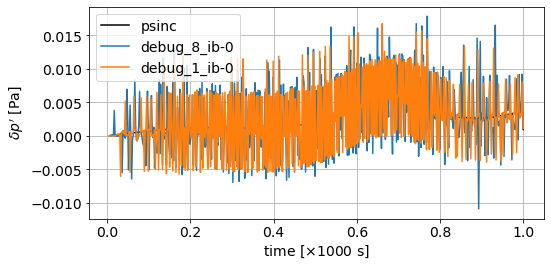

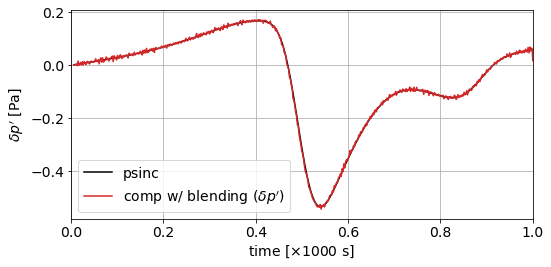

In [124]:
attributes = ['rho','rhou','rhov','rhoY','p2_nodes']
attributes = ['p2_nodes']
# attributes = ['p2_half']

base_fn = "output_rising_bubble"
directory = "output_rising_bubble"

py_directory = "../../%s/" %directory

et = 1.0
N = 1
Nx, Ny = 160, 80
tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)

p_ref = 8.61 * 1e4
# times = np.arange(0,527)[1:]#[:186]
times = np.arange(0,164)#[:19]
times = np.arange(0,154)#[:19]
times = np.arange(0,527)[1:]
# times = np.arange(0,30)

probe_loc = [20,40]
# probe_loc = [80,40]
l_typ = 'WINDOW_STEP'

rhoY = False
CFL = True

attr_labels = pt.labels_increment()

def p_converter(ens,rhoY,ud, sfx):
    dp2n = np.array([ (at_t - at_t.mean()) * ud.Msq for at_t in ens ])
    kernel = np.ones((2,2))
    dp2c = np.array([signal.fftconvolve(item, kernel, mode='valid') / kernel.sum() for item in dp2n])

    if 'psinc' in sfx:
        P0 = (rhoY**(ud.gamm-1.0) + dp2c)**(1.0/(ud.gamm-1.0))
        p = P0**(ud.gamm)
    else:
        P0 = (rhoY**(ud.gamm-1.0) - dp2c)**(1.0/(ud.gamm-1.0))
        p = rhoY**(ud.gamm) - P0**(ud.gamm)

#     if 'psinc' in sfx:
#         p = (rhoY**(ud.gamm-1.0) + dp2c)**(1.0/(ud.gamm-1.0))
#         p = p**(ud.gamm)
#     else:
#         p = rhoY**(ud.gamm)

#     p = rhoY**(ud.gamm)
    p *= ud.p_ref
    return p

def get_ens(sfx , diff, attribute):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=False)
    rhoY = tc.get_ensemble(times, N, 'rhoY', sfx, label_type=l_typ, avg=True, diff=False)
    rho = tc.get_ensemble(times, N, 'rho', sfx, label_type=l_typ, avg=True, diff=False)
    tt = tc.t_arr
    ens = ens[1:]
    rhoY = rhoY[1:]
    rho = rho[1:]
    tt = tt[1:]
    
    ud = ic_loader(tc,sfx,False)
    p = p_converter(ens,rhoY,ud, sfx)
    probe = p[:,probe_loc[0],probe_loc[1]]
    probe = probe[1:] - probe[:-1]

#     if True:
#         Y = rhoY / rho
#         Y = Y.mean(axis=1)[:,39]
#         rho_avg = rho.mean(axis=1)[:,39]
#         p = rho_avg * Y
#         p = p**(ud.gamm)
#         p *= ud.p_ref
#         probe = p
    
#     if True:
#         p = rhoY**(ud.gamm)
#         p *= ud.p_ref
#         probe = p.mean(axis=1)[:,39]
#     print(p.shape)
    
    label = sfx + '_' + attribute
    return label, probe, tt

pls = []
ss = 'idt=2'

for i,attribute in enumerate(attributes):
    diff = True if attribute == 'p2_nodes' or attribute == 'p2_half' else False

    sfx1 = 'psinc_noib'
    if CFL : sfx1 = 'psinc_noib_CFLfixed'
    if CFL : sfx1 = 'psinc_noib'
    attribute1 = 'p2_nodes'
    if rhoY : attribute1 = 'rhoY'
    l1, p1, tt = get_ens(sfx1, diff, attribute1)
    l1 = 'psinc'
    
    sfx2 = 'comp_imbal_noib'
    if CFL : sfx2 = 'comp_imbal_noib_CFLfixed'
    if CFL : sfx2 = 'debug_CFLfixed_1_ib-0'
    if CFL : sfx2 = 'debug_8_ib-0'
    attribute2 = 'p2_nodes'
    if rhoY : attribute2 = 'rhoY'
    l2_attr = np.copy(attribute2)
    l2, p2, tt = get_ens(sfx2, diff, attribute2)
    l2 = 'comp w/o blending'
    
    sfx3 = 'comp_imbal_half_ib-0'
    if CFL : sfx3 = 'comp_imbal_half_CFLfixed_ib-0'
    if CFL : sfx3 = 'debug_CFLfixed_4_ib-0'
    if CFL : sfx3 = 'debug_1_ib-0'
    attribute3 = 'p2_nodes'
    if rhoY : attribute3 = 'rhoY'
    l3, p3, tt = get_ens(sfx3, diff, attribute3)
    l3 = 'comp w/ blending'

    fs = (20*cm,10*cm) # used in the publication
    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)
    
    if diff == True:
        tt = tt[1:]
    
    ax.plot(tt, p1, 'k', ms=4, label=l1)
    ax.plot(tt, p2, 'C0', label=sfx2)
    ax.plot(tt, p3, 'C1', ms=6, markevery=1, label=sfx3)
    
    fn = 'rb_slides'
    
    ax.set_ylabel(r'$\delta p^\prime$ [Pa]')
    ax.set_xlabel(r'time [$\times 1000$ s]')
#     ax.set_xlim([0.0,0.35])
    ax.grid()
    ax.legend()
    
    l3a = ''
    l3a += r'$\delta_{\rm{i}}$=%.4f' %((la.norm(p2[1:]-p1[1:]))/la.norm(p1[1:]))
    l3a += '\n'
    l3a += r'$\delta_{\rm{b}}$=%.4f' %((la.norm(p3[1:]-p1[1:]))/la.norm(p1[1:]))
#     ax.annotate(l3a, (0.03,-0.034))
    
    pl.img.tight_layout()
    
#     fn = 'rb_cfl_%i_%i' %(probe_loc[0],probe_loc[1])
#     pl.save_fig('./output/%s' %fn)
    
#     print("probe_loc = (%i, %i)" %(probe_loc[0],probe_loc[1]))
#     print("w/o blending - psinc: %.6f" %(la.norm(p2-p1)))
#     print("blending - psinc: %.6f" %(la.norm(p3[1:]-p1[1:])))
    
    print(l3a)
    
    ########################################
    #
    ########################################
    print("====================")
    
    probe_loc = [80,40]
    _, p1, _ = get_ens(sfx1, diff, attribute1)
    _, p2, _ = get_ens(sfx2, diff, attribute2)
    _, p3, _ = get_ens(sfx3, diff, attribute3)
    
    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)
    
    ax.plot(tt, p1, 'k', ms=4, label=l1)
#     ax.plot(tt, p2, 'C0', label=sfx2)
    exta = ' $(\delta p^\prime)$'
#     extb = ' $(\delta p)$'
    ax.plot(tt, p3, 'C3', ms=6, markevery=1, label=l3 + exta)
    
    fn = 'rb_slides'
    
    ax.set_ylabel(r'$\delta p^\prime$ [Pa]')
    ax.set_xlabel(r'time [$\times 1000$ s]')
    ax.set_xlim([0.0,1.0])
    ax.grid()
    ax.legend()
    
    l3b = ''
    l3b += r'$\delta_{\rm{i}}$=%.4f' %((la.norm(p2[1:]-p1[1:]))/la.norm(p1[1:]))
    l3b += '\n'
    l3b += r'$\delta_{\rm{b}}$=%.4f' %((la.norm(p3[1:]-p1[1:]))/la.norm(p1[1:]))
    l3b = ''
    l3b += r'$\delta_{\rm{i}}$=%.4f' %((la.norm(p2[1:]-p1[1:]))/la.norm(p1[1:]))
    l3b += '\n'
    l3b += r'$\delta_{\rm{b}}$=%.4f' %((la.norm(p3[2:]-p1[2:]))/la.norm(p1[2:]))
#     ax.annotate(l3b, (0.82,-0.68))
    
    pl.img.tight_layout()
    
    fn = 'rb_deltapp'
    pl.save_fig('./output/%s' %fn)
    
#     print("probe_loc = (%i, %i)" %(probe_loc[0],probe_loc[1]))
#     print("%s - psinc: %.6f" %(sfx2, la.norm(p2[1:]-p1[1:])/la.norm(p1[1:])))
#     print("%s - psinc: %.6f" %(sfx3, la.norm(p3[1:]-p1[1:])/la.norm(p1[1:])))
    
    print(l3b)
    
        ########################################
    #
    ########################################